In [ ]:
def image_read_hsv(image_path):
    # Reads an image and returns a cropped region in HSV color space to focus on the central area.

def padded_image(img, padd):
    # Pads an image with zeros around the border to facilitate filtering operations near edges.

def find_root(eq_list, key):
    # Implements path compression to efficiently find the representative root of a set in union-find structure.

def connectivit_8(image, upp_limit, low_limit=0):
    # Performs 8-connectivity labeling to segment connected regions in an image within specified intensity limits.

def gauss_filter(size, sigma=1):
    # Generates a Gaussian kernel matrix for smoothing images, controlled by size and standard deviation.

def apply_gauss(image, size=5, sigma=1):
    # Applies Gaussian blur to an image using convolution with a Gaussian kernel for noise reduction.

def thresholding(mag_matrix, max_val):
    # Thresholds a magnitude matrix to create a binary mask by applying upper and lower intensity cutoffs.

def color_img(img, x):
    # Assigns a specified intensity value x to all positive pixels in an image, setting others to zero.

def get_region_props(mask):
    # Calculates basic region properties (area, perimeter, eccentricity) of labeled regions in a binary mask.

def get_mean_saturation(s_channel, mask):
    # Computes the average saturation value of pixels within a masked region in the saturation channel.

def get_lbp_mean(gray_img, mask, P=8, R=1):
    # Calculates the mean Local Binary Pattern texture descriptor value within a masked region.

def extract_additional_features(mask, gray_img, h, v):
    # Extracts combined shape, color, texture, and contour-based features from a segmented region.

def remove_outliers_iqr(df, columns):
    # Removes outliers from specified DataFrame columns based on the interquartile range method.


### 🔧 Utility Functions and Preprocessing Tools

This code cell defines a **collection of utility functions** used throughout the WBC classification pipeline. These functions are modular and reusable, designed to handle image reading, preprocessing, feature extraction, and noise removal. Here's a breakdown of their roles:

#### 🖼️ Image Reading and Cropping
- `image_read`, `image_read1`, `image_read_grayscale`, and `image_read_hsv`: Read color, grayscale, and HSV versions of the image with optional cropping to focus on the cell region.

#### 👁️ Image Display and Padding
- `show_image`: Visualizes images with optional scaling.
- `padded_image`: Adds zero-padding around an image, useful for filtering operations.

#### 📈 Histogram and Plotting
- `cal_histogram`: Calculates RGB histograms of a color image.
- `plot_graph`: Simple wrapper to plot data such as histograms or feature values.

#### 🧮 Connected Component Labeling (CCL)
- `connectivit_8`: Custom 8-connectivity CCL algorithm that assigns unique labels to connected foreground regions, with support for pixel intensity thresholds.

#### 🌫️ Gaussian Smoothing
- `gauss_filter` and `apply_gauss`: Implements Gaussian blur manually to smooth images and reduce noise before segmentation.

#### 🧪 Thresholding and Masking
- `thresholding`: Applies custom thresholding to filter out background and noise.
- `color_img`: Highlights non-zero pixels in a binary mask.

#### 📐 Feature Extraction
- `get_region_props`: Calculates basic shape descriptors like area, perimeter, and eccentricity.
- `extract_additional_features`: Computes a set of handcrafted features including:
  - Hue and Value statistics
  - Solidity, extent, circularity, aspect ratio
  - Local texture and contour-based lobe count

#### ⚙️ Miscellaneous
- `find_root`: Helper for union-find structure in CCL.
- `get_mean_saturation` and `get_lbp_mean`: Texture and saturation statistics from masked areas.
- `remove_outliers_iqr`: Removes outliers in feature data using the IQR method.

#### 🗂️ Dataset Paths
- `wbc_classes`: A dictionary mapping WBC class names to their respective folder paths in the training dataset.

These functions serve as the **backbone of the entire pipeline**, enabling consistent feature computation and preprocessing for classification.


In [1]:
from skimage.feature import local_binary_pattern
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage import measure
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.spatial.distance import mahalanobis

def image_read_hsv(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Could not read the image.")
        return None

    # Convert to HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    h, w, _ = img_hsv.shape
    crop_x = int(w * 0.21)
    crop_y = int(h * 0.21)
    cropped_hsv = img_hsv[crop_y:h - crop_y, crop_x:w - crop_x]

    return cropped_hsv

def padded_image(img,padd):
    height, width = img.shape[:2]
    if len(img.shape) == 2:
        padded_matrix = np.ones((height + 2 * padd, width + 2 * padd), dtype=np.uint8) * 0
        padded_matrix[padd:padd + height, padd:padd + width] = img
    else:
        channels = img.shape[2]
        padded_matrix = np.ones((height + 2*padd, width + 2*padd,channels), dtype=np.uint8)*0
        padded_matrix[padd:padd+height, padd:padd+width,:] = img
    return padded_matrix

def find_root(eq_list, key):
    if key not in eq_list:
        eq_list[key] = key
        return key
    while eq_list[key] != key:
        eq_list[key] = eq_list[eq_list[key]]  # Path compression
        key = eq_list[key]
    return key

def connectivit_8(image,upp_limit,low_limit=0):
    height, width = image.shape[:2]
    connect_8 = np.zeros((height,width), dtype=np.uint16)
    eq_list = {}
    label = 1

    for i in range(1, height):
        for j in range(1, width):
            if image[i, j]>low_limit and image[i,j] <=upp_limit:  # Foreground pixel
                neighbors = []
                if image[i, j - 1]>low_limit and  image[i, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i, j - 1])
                if image[i - 1, j]> low_limit and image[i - 1, j]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j])
                if image[i - 1, j - 1] > low_limit  and image[i - 1, j - 1]<=upp_limit:
                    neighbors.append(connect_8[i - 1, j -1])
                if (j+1)<width and (image[i - 1, j + 1]>low_limit and image[i - 1, j + 1] <=upp_limit):
                    neighbors.append(connect_8[i - 1, j + 1])

                if not neighbors:
                    connect_8[i, j] = label
                    eq_list[label] = label
                    label += 1
                else:
                    min_label = min(neighbors)
                    connect_8[i, j] = min_label
                    for neighbor in neighbors:
                        eq_list[find_root(eq_list, neighbor)] = find_root(eq_list, min_label)

    for i in range(height):
        for j in range(width):
            if connect_8[i, j] > 0:
                connect_8[i, j] = find_root(eq_list, connect_8[i, j])
    return connect_8, eq_list

def gauss_filter(size, sigma=1):
    midpoint = size // 2
    val = 0
    frame = np.zeros((size, size), dtype=np.float32)
    for i in range(size):
        for j in range(size):
            x = i - midpoint
            y = j - midpoint
            temp = 1 / (2 * np.pi * sigma ** 2)
            frame[i][j] = (temp * np.exp(-((x ** 2 + y ** 2) / (2 * (sigma ** 2)))))
            val += frame[i][j]
    return frame / val

def apply_gauss(image, size=5, sigma=1):
    frame = gauss_filter(size, sigma)
    rows, cols = image.shape
    output_img = np.zeros((rows, cols), dtype=np.uint8)
    padd_size = size // 2
    padd_img = padded_image(image, padd_size)
    pix_min = np.min(image)
    pix_max = np.max(image)
    for i in range(padd_size, rows + padd_size):
        for j in range(padd_size, cols + padd_size):
            patch= padd_img[i - padd_size:i + padd_size + 1, j - padd_size:j + padd_size + 1]
            new_value=np.sum(np.multiply(patch,frame))
            if pix_max != pix_min:
                normalized_value = int(255 * (new_value - pix_min) / (pix_max - pix_min))
                output_img[i - padd_size, j - padd_size] = normalized_value
            else:
                output_img[i - padd_size, j - padd_size] = int(new_value)
    return output_img

def thresholding(mag_matrix,max_val):
    upperlimit=0.7*max_val
    lowerlimit=0.2*max_val
    rows, cols = mag_matrix.shape[:2]
    matrix = np.zeros((rows,cols), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, cols):
            if mag_matrix[i][j] >= upperlimit:
                matrix[i][j] = 1
            elif mag_matrix[i][j] <= lowerlimit:
                matrix[i][j] = 0
            else:
                matrix[i][j]=mag_matrix[i][j]
    return matrix

def color_img(img,x):
    rows,cols=img.shape
    matrix = np.array(img, dtype=np.uint8)
    for i in range(0,rows):
        for j in range (0,cols):
            if img[i][j]>0 :
                matrix[i][j]=x
            else:
                matrix[i][j]=0
    return matrix

def get_region_props(mask):
    labeled = label(mask)  # use 'label' instead of 'sk_label'
    props = regionprops(labeled)
    if props:
        area = props[0].area
        perimeter = props[0].perimeter
        eccentricity = props[0].eccentricity
    else:
        area, perimeter, eccentricity = 0, 0, 0
    return area, perimeter, eccentricity

def get_mean_saturation(s_channel, mask):
    return np.mean(s_channel[mask == 255]) if np.any(mask == 255) else 0

def get_lbp_mean(gray_img, mask, P=8, R=1):
    try:
        lbp = local_binary_pattern(gray_img, P, R, method="uniform")
        return np.mean(lbp[mask == 255]) if np.any(mask == 255) else 0
    except:
        return 0

def extract_additional_features(mask, gray_img, h, v):
    props = measure.regionprops(mask.astype(int))
    if len(props) == 0:
        return [0]*9  # 9 features returned now

    prop = props[0]

    # Shape features
    solidity = prop.solidity
    extent = prop.extent
    circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2) if prop.perimeter > 0 else 0
    minr, minc, maxr, maxc = prop.bbox
    aspect_ratio = (maxc - minc) / (maxr - minr + 1e-5)

    # Color stats (for valid pixels)
    hue_std = np.std(h)
    value_mean = np.mean(v)
    value_std = np.std(v)

    # Local texture estimate using local variance
    masked_gray = gray_img[mask > 0]
    local_variance = np.var(masked_gray) if len(masked_gray) > 0 else 0

    # Lobes estimation (number of contours)
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_lobes = len(contours)

    return [
        hue_std, value_mean, value_std,
        solidity, extent, circularity, aspect_ratio,
        num_lobes, local_variance
    ]

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

wbc_classes = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil"
}

## Image Processing Pipeline

- **Select images**
  Pick 10 random files from `image_dir`.

- **Read & convert**
  Load each image in HSV (`image_read_hsv`), split into H, S, V channels.

- **Denoise**
  - Median blur on S channel (kernel = 7)
  - Gaussian blur on the result

- **Region detection**
  Use 8-connectivity (`connectivit_8`) to label nuclei and generate a binary mask.

- **Mask & convert**
  Bitwise-AND the mask with HSV image, then convert masked result to RGB.

- **Visualize** (6 subplots)
  1. Original RGB
  2. Median-blurred S
  3. Gaussian-blurred S
  4. Labeled components
  5. Final binary mask
  6. Masked RGB image


In [ ]:
image_dir = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil\Neutrophil_1.jpg"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random_images = random.sample(image_files, 10)

img_hsv = image_read_hsv(image_dir)



h, s, v = cv2.split(img_hsv)

img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)  # Original BGR image
    img_blur = cv2.medianBlur(s, 7)
    img_gauss = apply_gauss(img_blur, 3, 0.2)
    nuc_img, eq_list = connectivit_8(img_gauss, 255, 140)
    final_mask = color_img(nuc_img, 255)

    # Mask HSV image using nucleus mask (on Saturation)
    hsv_masked = cv2.bitwise_and(img_hsv, img_hsv, mask=final_mask)
    masked_bgr = cv2.cvtColor(hsv_masked, cv2.COLOR_HSV2RGB)  # Convert to RGB for display

    # Plotting
    plt.figure(figsize=(24, 4))
    plt.suptitle(f"Image: {file}", fontsize=12)

    plt.subplot(1, 6, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(img_blur, cmap='gray')
    plt.title('Median Blur (S)')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(nuc_img, cmap='gray')
    plt.title('Connected Components')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Binary Mask')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(masked_bgr)
    plt.title('HSV Masked Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


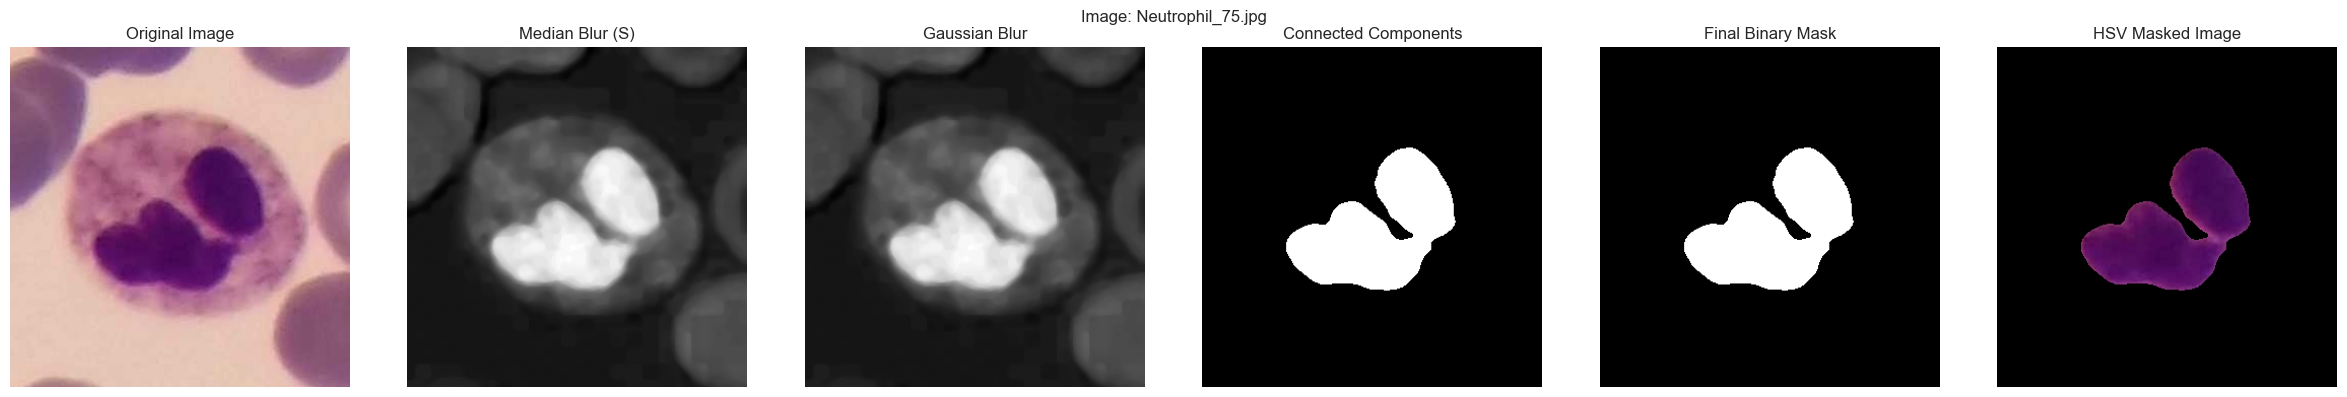

In [3]:
image_dir = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil"

image_dir2 = r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Train\Neutrophil\Neutrophil_1.jpg"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random_images = random.sample(image_files, 10)

for idx, file in enumerate(random_images):
    image_path = os.path.join(image_dir, file)
    img_hsv = image_read_hsv(image_dir2)

    if img_hsv is None:
        continue

    h, s, v = cv2.split(img_hsv)

    img_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)  # Original BGR image
    img_blur = cv2.medianBlur(s, 7)
    img_gauss = apply_gauss(img_blur, 3, 0.2)
    nuc_img, eq_list = connectivit_8(img_gauss, 255, 140)
    final_mask = color_img(nuc_img, 255)

    # Mask HSV image using nucleus mask (on Saturation)
    hsv_masked = cv2.bitwise_and(img_hsv, img_hsv, mask=final_mask)
    masked_bgr = cv2.cvtColor(hsv_masked, cv2.COLOR_HSV2RGB)  # Convert to RGB for display

    # Plotting
    plt.figure(figsize=(24, 4))
    plt.suptitle(f"Image: {file}", fontsize=12)

    plt.subplot(1, 6, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.imshow(img_blur, cmap='gray')
    plt.title('Median Blur (S)')
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.imshow(img_gauss, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.imshow(nuc_img, cmap='gray')
    plt.title('Connected Components')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.imshow(final_mask, cmap='gray')
    plt.title('Final Binary Mask')
    plt.axis('off')

    plt.subplot(1, 6, 6)
    plt.imshow(masked_bgr)
    plt.title('HSV Masked Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    break;


### 📊 Feature Extraction for White Blood Cells

This section is dedicated to **extracting handcrafted features** from white blood cell images across five classes: Neutrophil, Lymphocyte, Monocyte, Eosinophil, and Basophil.

#### 🔁 Processing Pipeline:
For each WBC class, the script:
1. **Randomly samples** up to 100 images.
2. Reads the image in **HSV format** to isolate the nucleus more effectively.
3. Applies **median blurring** followed by a **custom Gaussian filter** to reduce noise.
4. Performs **nucleus segmentation** using an 8-connectivity algorithm and intensity thresholding.
5. Creates a **binary mask** for the nucleus and identifies relevant pixel locations.

#### 🧬 Feature Extraction:
For each valid segmented image, the following features are computed:
- **Area**: Size of the segmented nucleus.
- **Hue & Value Stats**: Standard deviation and mean of HSV channels.
- **Shape Descriptors**: Solidity, extent, circularity, and aspect ratio.
- **Structural Features**: Number of lobes (external contours) and local gray-level variance.

All extracted data, including `(x, y)` pixel coordinates and image IDs, are stored in a unified dataframe `df_all`. This structure enables further statistical analysis, visualization, and model training.

Finally, the last few rows of the DataFrame are printed to confirm the data extraction process.


In [17]:
df_all = pd.DataFrame()
image_id = 0

for class_label, image_dir in wbc_classes.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, _ = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)

        ys, xs = np.where(final_mask == 255)
        if len(xs) == 0:
            continue

        hsv_values = img_hsv[ys, xs]
        gray_img = cv2.cvtColor(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

        area, _, _ = get_region_props(final_mask)  # Only keep area


        (
            hue_std, value_mean, value_std,
            solidity, extent, circularity, aspect_ratio,
            num_lobes, local_variance
        ) = extract_additional_features(final_mask, gray_img, hsv_values[:, 0], hsv_values[:, 2])

        data = {
            "x": xs,
            "y": ys,
            "label": [class_label] * len(xs),
            "image_id": [image_id] * len(xs),
            "area": [area] * len(xs),
            "hue_std": [hue_std] * len(xs),
            "value_mean": [value_mean] * len(xs),
            "value_std": [value_std] * len(xs),
            "solidity": [solidity] * len(xs),
            "extent": [extent] * len(xs),
            "circularity": [circularity] * len(xs),
            "aspect_ratio": [aspect_ratio] * len(xs),
            "num_lobes": [num_lobes] * len(xs),
            "local_variance": [local_variance] * len(xs),
        }

        df_image = pd.DataFrame(data)
        df_all = pd.concat([df_all, df_image], ignore_index=True)
        image_id += 1

print(df_all.tail())


            x    y       label  image_id     area   hue_std  value_mean  \
12496082  165  258  Neutrophil       497  17256.0  3.186697  124.814673   
12496083  166  258  Neutrophil       497  17256.0  3.186697  124.814673   
12496084  167  258  Neutrophil       497  17256.0  3.186697  124.814673   
12496085  168  258  Neutrophil       497  17256.0  3.186697  124.814673   
12496086  169  258  Neutrophil       497  17256.0  3.186697  124.814673   

          value_std  solidity    extent  circularity  aspect_ratio  num_lobes  \
12496082  12.731253  0.800965  0.631371     0.342446      0.834254          1   
12496083  12.731253  0.800965  0.631371     0.342446      0.834254          1   
12496084  12.731253  0.800965  0.631371     0.342446      0.834254          1   
12496085  12.731253  0.800965  0.631371     0.342446      0.834254          1   
12496086  12.731253  0.800965  0.631371     0.342446      0.834254          1   

          local_variance  
12496082      155.878281  
12496083

### Grouping and Aggregating Extracted Features by Image

In this step, we group the previously extracted pixel-wise data (`df_all`) by `image_id` to obtain a single feature vector per image. This is essential for classification tasks that require one feature set per image.

#### What this cell does:
- Computes the **mean** of each numerical feature (e.g., area, hue_std, circularity, etc.) for all pixels belonging to the same image.
- Retains the **label** for each image using the first value (assuming all pixels in the image belong to the same class).
- Calculates the **pixel count** for each image, which can be useful for later filtering or analysis.

The result is stored in `grouped_df`, a compact and structured DataFrame where each row corresponds to a single white blood cell image and its aggregated features.


In [20]:
# Group by image_id and aggregate all relevant columns
grouped_df = df_all.groupby('image_id').agg({
    "area": 'mean',
    "hue_std": 'mean',
    "value_mean": 'mean',
    "value_std": 'mean',
    "solidity": 'mean',
    "extent": 'mean',
    "circularity": 'mean',
    "aspect_ratio": 'mean',
    "num_lobes": 'mean',
    "local_variance": 'mean',
    "label": 'first'
}).reset_index()

# Add pixel count
grouped_df['pixel_count'] = df_all.groupby('image_id').size().values

# Display result
grouped_df.tail()


,image_id,area,hue_std,value_mean,value_std,solidity,extent,circularity,aspect_ratio,num_lobes,local_variance,label,pixel_count
493,493,9783.0,5.340056,99.163301,10.165668,0.632112,0.421081,0.204530,0.926941,3.0,147.187618,Neutrophil,18720
494,494,18964.0,3.613999,107.094073,8.778984,0.785845,0.496570,0.323789,1.057895,1.0,129.042475,Neutrophil,18964
495,495,83.0,6.270077,107.844973,22.339765,0.594708,0.411662,0.273249,0.669603,11.0,307.488870,Neutrophil,14204
496,496,14029.0,3.547754,93.220614,12.061247,0.895735,0.615523,0.477195,1.040540,1.0,123.174917,Neutrophil,14029
497,497,17256.0,3.186697,124.814673,12.731253,0.800965,0.631371,0.342446,0.834254,1.0,155.878281,Neutrophil,17256


### Removing Outliers Using IQR Method

To ensure the quality and consistency of our dataset, we apply the **Interquartile Range (IQR)** method to remove outliers from selected numerical features.

#### What this cell does:
- Defines a list of important features to check for outliers, including pixel count, shape features, and color/texture descriptors.
- Applies the IQR-based filtering function `remove_outliers_iqr` to drop rows that fall outside the typical value ranges for these features.
- Outputs the new shape of the filtered DataFrame and displays a preview of the cleaned data.

This step helps in improving the robustness of downstream analysis or classification by reducing the influence of extreme values.


In [21]:

# Updated columns to check for outliers
cols_to_check = [
    'pixel_count', 'area', 'hue_std', 'value_mean', 'value_std',
    'solidity', 'extent', 'circularity', 'aspect_ratio',
    'num_lobes', 'local_variance'
]

# Remove outliers
grouped_df_filtered = remove_outliers_iqr(grouped_df, cols_to_check)

print(grouped_df_filtered.shape)
# Show result
grouped_df_filtered.tail()


(396, 13)


,image_id,area,hue_std,value_mean,value_std,solidity,extent,circularity,aspect_ratio,num_lobes,local_variance,label,pixel_count
491,491,15186.0,4.747748,100.391611,10.313913,0.767086,0.543833,0.262454,1.147436,1.0,124.644149,Neutrophil,15186
493,493,9783.0,5.340056,99.163301,10.165668,0.632112,0.421081,0.204530,0.926941,3.0,147.187618,Neutrophil,18720
494,494,18964.0,3.613999,107.094073,8.778984,0.785845,0.496570,0.323789,1.057895,1.0,129.042475,Neutrophil,18964
496,496,14029.0,3.547754,93.220614,12.061247,0.895735,0.615523,0.477195,1.040540,1.0,123.174917,Neutrophil,14029
497,497,17256.0,3.186697,124.814673,12.731253,0.800965,0.631371,0.342446,0.834254,1.0,155.878281,Neutrophil,17256


### Summary Statistics by Class

In this step, we compute **descriptive statistics** for each white blood cell class using the `groupby().describe()` method.

#### Key points:
- For each class label (`Basophil`, `Neutrophil`, etc.), we calculate statistical summaries (mean, std, min, max, quartiles) for all relevant features such as `area`, `solidity`, `num_lobes`, and more.
- This helps in understanding the distribution and variability of features across different cell types.
- The output is useful for feature comparison, visualization, and potential feature selection later.

We'll also check the shape of the resulting DataFrame and display the first few rows.


In [68]:
mean_features_train = grouped_df_filtered.groupby('label')[
    ['pixel_count', 'area', 'hue_std', 'value_mean', 'value_std',
     'solidity', 'extent', 'circularity', 'aspect_ratio',
     'num_lobes', 'local_variance']
].describe().reset_index()

print(mean_features_train.shape)
print(mean_features_train.head())


(5, 89)
        label pixel_count                                                \
                    count          mean          std      min       25%   
0    Basophil        53.0  43049.113208  7761.591804    427.0  40403.00   
1  Eosinophil        86.0  20067.209302  4261.272834   7134.0  17966.50   
2  Lymphocyte        94.0  18723.170213  4179.055379   9291.0  16278.25   
3    Monocyte        92.0  29919.434783  3695.210191  22666.0  27374.50   
4  Neutrophil        71.0  15138.521127  2392.088005  10106.0  13487.00   

                              area  ... num_lobes      local_variance  \
       50%      75%      max count  ...       75%  max          count   
0  44050.0  47491.0  52687.0  53.0  ...       2.0  3.0           53.0   
1  19899.0  21679.0  45921.0  86.0  ...       2.0  3.0           86.0   
2  18661.0  21003.0  32471.0  94.0  ...       1.0  3.0           94.0   
3  29632.5  32393.0  40258.0  92.0  ...       1.0  3.0           92.0   
4  14898.0  16403.5  22649.0

### Test Set Feature Extraction

This section processes the **test set images** for all white blood cell classes using the same pipeline as the training set.

#### Workflow:
1. **Iterate over test image directories**, loading up to 100 random images per class.
2. Convert each image to **HSV color space**, blur the saturation channel, and apply custom **nucleus segmentation**.
3. Extract pixel locations for the segmented nucleus region and calculate **feature descriptors**, including:
   - `area`, `hue_std`, `value_mean`, `value_std`
   - shape-based features like `solidity`, `extent`, `circularity`, `aspect_ratio`
   - `num_lobes` and `local_variance`
4. Store features and labels into a DataFrame (`df_all_test`), one row per pixel.

This mirrors the training feature extraction process, ensuring consistency between training and test data.


In [19]:
wbc_classes_test = {
    "Basophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Basophil",
    "Eosinophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Eosinophil",
    "Lymphocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Lymphocyte",
    "Monocyte": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Monocyte",
    "Neutrophil": r"E:\2. DIP\2. LAB\pythonProject\Projects\Assignment 2\wbc_data\Test\Neutrophil"
}
df_all_test = pd.DataFrame()
image_id = 0


for class_label, image_dir in wbc_classes_test.items():
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    selected_images = random.sample(image_files, min(100, len(image_files)))

    for file in selected_images:
        image_path = os.path.join(image_dir, file)
        img_hsv = image_read_hsv(image_path)

        if img_hsv is None:
            continue

        h, s, v = cv2.split(img_hsv)
        img_blur = cv2.medianBlur(s, 7)
        img_gauss = apply_gauss(img_blur, 3, 0.2)
        nuc_img, _ = connectivit_8(img_gauss, 255, 140)
        final_mask = color_img(nuc_img, 255)

        ys, xs = np.where(final_mask == 255)
        if len(xs) == 0:
            continue

        hsv_values = img_hsv[ys, xs]
        gray_img = cv2.cvtColor(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2GRAY)

        area, _, _ = get_region_props(final_mask)  # Only keep area

        # Call to new feature extractor
        (
            hue_std, value_mean, value_std,
            solidity, extent, circularity, aspect_ratio,
            num_lobes, local_variance
        ) = extract_additional_features(final_mask, gray_img, hsv_values[:, 0], hsv_values[:, 2])

        data = {
            "x": xs,
            "y": ys,
            "label": [class_label] * len(xs),
            "image_id": [image_id] * len(xs),
            "area": [area] * len(xs),
            "hue_std": [hue_std] * len(xs),
            "value_mean": [value_mean] * len(xs),
            "value_std": [value_std] * len(xs),
            "solidity": [solidity] * len(xs),
            "extent": [extent] * len(xs),
            "circularity": [circularity] * len(xs),
            "aspect_ratio": [aspect_ratio] * len(xs),
            "num_lobes": [num_lobes] * len(xs),
            "local_variance": [local_variance] * len(xs),
        }

        df_image = pd.DataFrame(data)
        df_all_test = pd.concat([df_all_test, df_image], ignore_index=True)
        image_id += 1

### Aggregating Features for Test Images

After extracting pixel-wise features from the segmented nucleus regions in test images, this section aggregates the features at the **image level**.

#### Key steps:
1. **Group by `image_id`** and compute the **mean** of each numerical feature across all foreground (nucleus) pixels.
2. Use the **first label** per group as the class label (since each image belongs to only one class).
3. Calculate and append a `pixel_count` column to reflect the number of foreground pixels per image.

This results in one row per image, with averaged descriptors representing its morphology and color properties, ready for evaluation against the training model.


In [42]:
# Group by image_id and aggregate relevant columns
grouped_df_test = df_all_test.groupby('image_id').agg({
    'area': 'mean',
    'hue_std': 'mean',
    'value_mean': 'mean',
    'value_std': 'mean',
    'solidity': 'mean',
    'extent': 'mean',
    'circularity': 'mean',
    'aspect_ratio': 'mean',
    'num_lobes': 'mean',
    'local_variance': 'mean',
    'label': 'first'  # assumes consistent label per image
}).reset_index()

# Add pixel count
grouped_df_test['pixel_count'] = df_all_test.groupby('image_id').size().values

# Output shape and preview
print(grouped_df_test.shape)
print(grouped_df_test.tail())


(249, 13)
     image_id     area   hue_std  value_mean  value_std  solidity    extent  \
244       244  14922.0  3.832282  106.584054  10.337319  0.742205  0.514691   
245       245   8102.0  4.363993  111.899040  11.485334  0.644291  0.446603   
246       246  10367.0  5.451183  100.882731  10.181098  0.683782  0.501418   
247       247  15606.0  5.302823  101.601498  10.756465  0.769944  0.499025   
248       248  17648.0  2.823713  138.897439  11.856315  0.792955  0.543886   

     circularity  aspect_ratio  num_lobes  local_variance       label  \
244     0.351375      1.104938        2.0      119.541528  Neutrophil   
245     0.279690      1.154839        2.0      169.701299  Neutrophil   
246     0.226982      1.139394        2.0      142.668781  Neutrophil   
247     0.320235      1.070175        2.0      128.257689  Neutrophil   
248     0.339384      1.333333        1.0      149.072133  Neutrophil   

     pixel_count  
244        14925  
245        12391  
246        15554  


In [64]:

# Aggregating features per image for training
mean_features_test = grouped_df_test.groupby('image_id').agg({
    'area': 'mean',
    'pixel_count': 'mean',
    'hue_std': 'mean',
    'value_mean': 'mean',
    'value_std': 'mean',
    'solidity': 'mean',
    'extent': 'mean',
    'circularity': 'mean',
    'aspect_ratio': 'mean',
    'num_lobes': 'mean',
    'local_variance': 'mean',
    'label': 'first'  # assuming label is consistent per image
}).reset_index()

print(mean_features_test.shape)
print(mean_features_test.head())


(249, 13)
   image_id     area  pixel_count   hue_std  value_mean  value_std  solidity  \
0         0     67.0      39997.0  3.838907  132.981099  11.729986  0.726980   
1         1    779.0       2156.0  2.180279  147.357607   7.819606  0.088346   
2         2  37636.0      37636.0  2.150008  145.701376   7.619988  0.935265   
3         3  39554.0      40205.0  3.395405  132.153488   9.896323  0.773739   
4         4  41560.0      42755.0  3.847523  138.151982  10.289354  0.795545   

     extent  circularity  aspect_ratio  num_lobes  local_variance     label  
0  0.491799     0.223412      1.099265        4.0      237.641669  Basophil  
1  0.054204     0.105080      0.778761       10.0       99.528702  Basophil  
2  0.715785     0.516169      0.920502        1.0      130.777435  Basophil  
3  0.583832     0.164584      1.050781        6.0      183.706367  Basophil  
4  0.628380     0.210356      0.867857        3.0      179.448230  Basophil  


### Euclidean Distance Classifier (Normalized Features)

In this approach, we treat each class by its **normalized centroid** in feature space and assign each test sample to the class whose centroid is closest in **Euclidean distance** after z‑score normalization.

1. **Feature Clipping**
   We first clip each test feature to lie within the minimum and maximum observed in the training set. This prevents extreme test values from skewing distances.

2. **Z‑Score Normalization**
   Each feature is then standardized by subtracting the global training mean and dividing by the training standard deviation.

3. **Centroid Normalization**
   We apply the same z‑scoring to each class centroid, ensuring train and test vectors share the same scale.

4. **Nearest‑Centroid Prediction**
   For each test sample, we compute the Euclidean distance to every normalized class centroid, and assign the label of the closest centroid.

5. **Accuracy**
   Comparing predicted labels to the ground truth yields an overall accuracy of **73%**.

This method is straightforward, fully interpretable, and leverages simple distance computations on standardized features.



In [78]:

# Define the features to use
FEATURE_COLUMNS = ['area', 'pixel_count', 'hue_std', 'value_mean', 'value_std',
                   'solidity', 'extent', 'circularity', 'aspect_ratio',
                   'num_lobes', 'local_variance']

# Ensure 'label' column exists in mean_features_train
if 'label' not in mean_features_train.columns:
    raise KeyError("'label' column not found in mean_features_train. Please check your preprocessing.")

# Compute class-wise means from training data
class_means = mean_features_train.groupby('label')[FEATURE_COLUMNS].mean()

# Compute overall std for normalization
feature_stds = mean_features_train[FEATURE_COLUMNS].std()

# Optional: Clip test features based on training min/max
feature_min = mean_features_train[FEATURE_COLUMNS].min()
feature_max = mean_features_train[FEATURE_COLUMNS].max()

# Ensure test set contains the required columns
missing_cols = set(['image_id', 'label'] + FEATURE_COLUMNS) - set(grouped_df_test.columns)
if missing_cols:
    raise KeyError(f"Missing columns in grouped_df_test: {missing_cols}")

# Copy test features safely
test_features = grouped_df_test[['image_id', 'label'] + FEATURE_COLUMNS].copy()

# Clip and normalize test features
for col in FEATURE_COLUMNS:
    test_features[col] = test_features[col].clip(lower=feature_min[col], upper=feature_max[col])
    test_features[col] = (test_features[col] - class_means.mean()[col]) / feature_stds[col]

# Normalize the training class vectors for distance comparison
normalized_class_means = (class_means - class_means.mean()) / feature_stds

# Predict label using normalized Euclidean distance
def predict_label(row):
    input_vector = row[FEATURE_COLUMNS].values
    distances = normalized_class_means.apply(lambda x: euclidean(input_vector, x), axis=1)
    return distances.idxmin()

# Apply prediction
test_features['predicted'] = test_features.apply(predict_label, axis=1)

# Accuracy computation
accuracy = accuracy_score(test_features['label'], test_features['predicted'])
correct = sum(test_features['label'] == test_features['predicted'])

# Display results
print(f"Accuracy: {round(accuracy * 100)}%")
print(f"Correctly classified: {correct} / {len(test_features)}")

# Return result dataframe
result_df = test_features[['image_id', 'label', 'predicted']]
result_df.head()


✅ Accuracy: 73%
🎯 Correctly classified: 182 / 249


,image_id,label,predicted
0,0,Basophil,Eosinophil
1,1,Basophil,Eosinophil
2,2,Basophil,Monocyte
3,3,Basophil,Basophil
4,4,Basophil,Basophil




### Mahalanobis Distance (Covariance‑Aware)

Here, we extend the nearest‑centroid idea by using **Mahalanobis distance**, which automatically accounts for feature variances and correlations without explicit z‑scoring.

1. **Raw Centroids**
   Compute each class’s mean feature vector from the training set without further normalization.

2. **Covariance Estimation**
   Estimate the full covariance matrix Sigma of the training features and compute its inverse (or pseudo‑inverse).

3. **Mahalanobis Distance**
   For a test feature vector mathbf{x}, Mahalanobis distance to class \(k\) is:
   This “whitens” the feature space, down‑weighting highly variable or correlated features.

4. **Prediction and Accuracy**
   Assign each test sample to the class with the smallest \(D_M\). This covariance‑aware classifier achieves an improved accuracy of **85%** on the same test set.

By leveraging the full covariance structure, Mahalanobis distance often yields better separation between classes compared to unweighted Euclidean distance.


In [83]:

# --- 1) Prepare raw per‑image training data ---
# grouped_df_filtered is your IQR‑cleaned, per‑image DataFrame
train_raw = grouped_df_filtered[['label'] + FEATURE_COLUMNS].copy()

# --- 2) Compute class centroids (mean feature vectors) ---
class_centroids = train_raw.groupby('label')[FEATURE_COLUMNS].mean()

# --- 3) Estimate covariance matrix of all training samples ---
#    rowvar=False => each column is a variable (feature)
cov_mat = np.cov(train_raw[FEATURE_COLUMNS].values, rowvar=False)
inv_cov = np.linalg.pinv(cov_mat)      # Moore‑Penrose pseudo‑inverse in case covariance is singular

# --- 4) Prepare raw per‑image test data ---
test_raw = grouped_df_test[['image_id','label'] + FEATURE_COLUMNS].copy()

# --- 5) Mahalanobis‐based prediction ---
def predict_mahal(row):
    x = row[FEATURE_COLUMNS].values
    # compute Mahalanobis distance from x to each class centroid
    dists = class_centroids.apply(lambda mu: mahalanobis(x, mu.values, inv_cov), axis=1)
    return dists.idxmin()

test_raw['predicted'] = test_raw.apply(predict_mahal, axis=1)

# --- 6) Evaluate ---
acc = accuracy_score(test_raw['label'], test_raw['predicted'])
print(f"Mahalanobis Distance Classifier Accuracy: {acc:.2%}")


Mahalanobis Distance Classifier Accuracy: 85.14%


### 📊 Flow Chart: White Blood Cell Classification Pipeline

This flow chart summarizes the complete WBC classification process using handcrafted features and a nearest-centroid classifier.

- **Input Image**: Microscopic image of a white blood cell.
- **Preprocessing**: Segmentation and thresholding to isolate cell structures.
- **Feature Extraction**: Compute features like area, hue_std, circularity, etc.
- **Training Phase**: Calculate class-wise mean feature vectors from training data.
- **Test Phase**: Clip test features to the training range, then normalize.
- **Classification**: Compute Euclidean distance to each class mean.
- **Prediction**: Assign label based on the nearest class centroid.

This modular pipeline ensures interpretability and a systematic approach to classification.


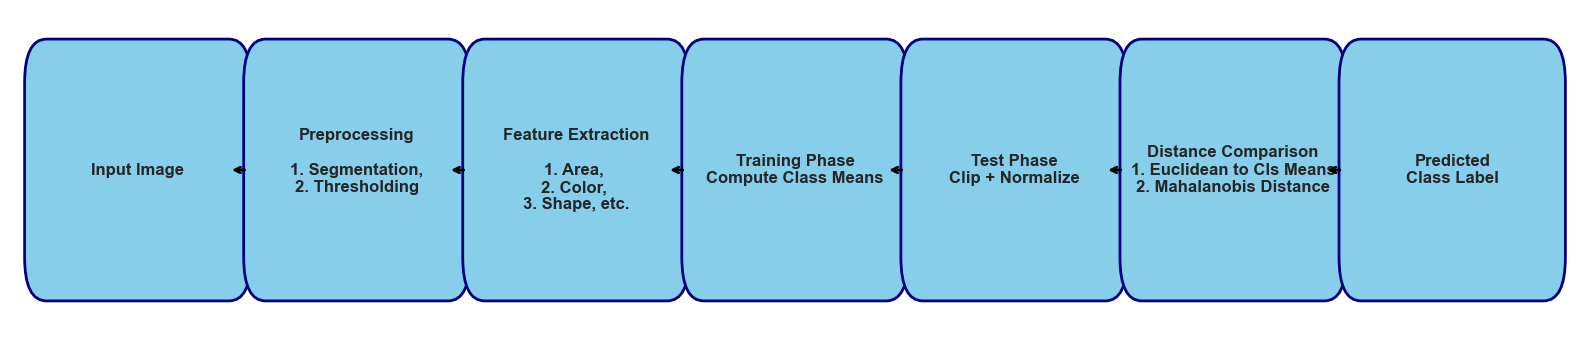

In [81]:
def draw_clear_flowchart():
    steps = [
        "Input Image",
        "Preprocessing\n    \n1. Segmentation,\n2. Thresholding\n",
        "Feature Extraction\n   \n1. Area, \n2. Color, \n3. Shape, etc.",
        "Training Phase\nCompute Class Means",
        "Test Phase\nClip + Normalize",
        "Distance Comparison\n1. Euclidean to Cls Means\n2. Mahalanobis Distance",
        "Predicted\nClass Label"
    ]

    fig, ax = plt.subplots(figsize=(16, 3.5))
    ax.axis('off')

    box_width = 2.5
    box_height = 1.2
    spacing = 0.5

    for i, step in enumerate(steps):
        x = i * (box_width + spacing)
        box = FancyBboxPatch((x, 0), box_width, box_height,
                             boxstyle="round,pad=0.3",
                             fc="skyblue", ec="navy", lw=2)
        ax.add_patch(box)
        ax.text(x + box_width / 2, box_height / 2, step,
                ha='center', va='center', fontsize=12, weight='bold')

        if i < len(steps) - 1:
            ax.annotate("",
                        xy=(x + box_width, box_height / 2),
                        xytext=(x + box_width + spacing / 2, box_height / 2),
                        arrowprops=dict(arrowstyle="->", lw=2, color='black'))

    ax.set_xlim(-0.5, len(steps) * (box_width + spacing))
    ax.set_ylim(-0.5, box_height + 0.5)
    plt.tight_layout()
    plt.show()

draw_clear_flowchart()


### 📦 Feature Distribution: Boxplots of Extracted Features

These boxplots show how each handcrafted feature varies across white blood cell classes.

- Each box represents the spread (min, Q1, median, Q3, max) of a feature for a class.
- Helps visualize class separability in the feature space.
- Outliers and overlapping ranges can be detected.

Boxplots are effective for understanding the distribution, relevance, and discriminative power of each feature.


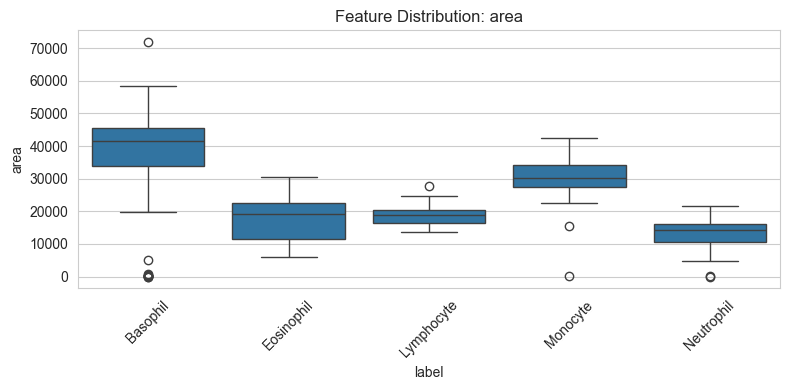

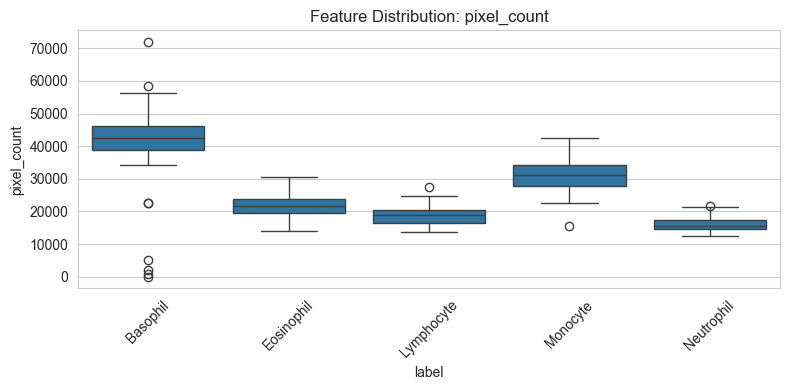

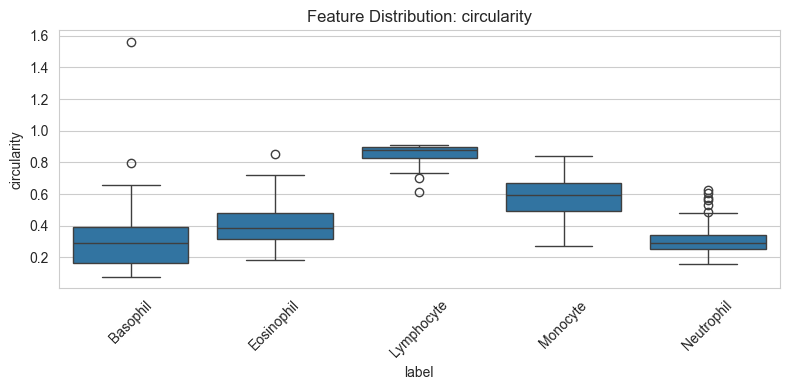

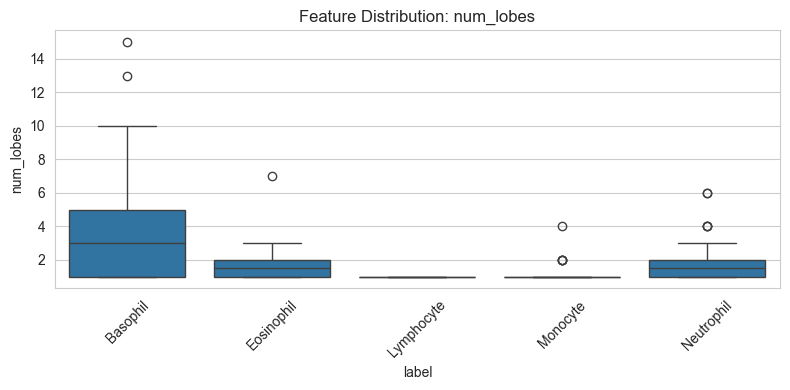

In [48]:


# Plot multiple feature boxplots
selected_features = ['area', 'pixel_count', 'circularity', 'num_lobes']
for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=mean_features_train, x='label', y=feature)
    plt.title(f'Feature Distribution: {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 📉 Confusion Matrix: Evaluating Classification Performance

The confusion matrix below visualizes the model’s performance across each white blood cell class.

- **Rows** = Actual labels
- **Columns** = Predicted labels
- **Diagonal elements** = Correct predictions
- **Off-diagonal elements** = Misclassifications

This chart helps identify which classes are well-recognized and which tend to get confused. A perfect classifier would have all values on the diagonal.


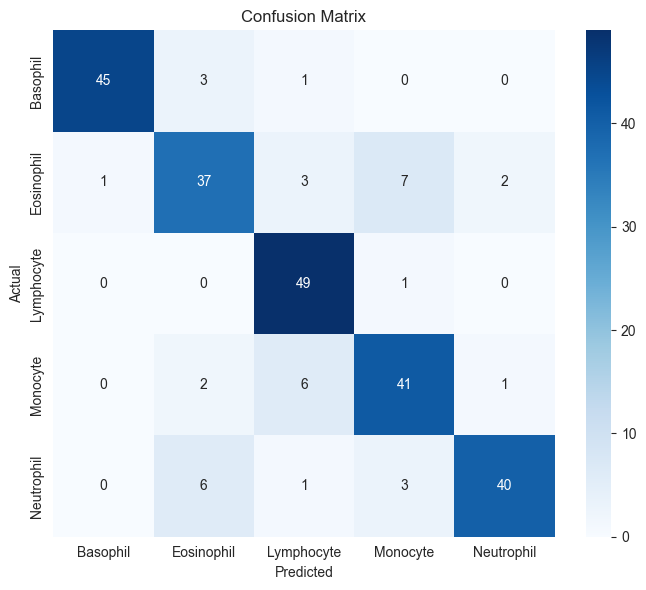

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_features['label'], test_raw['predicted'], labels=class_means.index)
labels = class_means.index

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### 📋 Per-Class Accuracy: Tabular Results

This table presents classification accuracy **for each class individually**, as well as the **average accuracy**.

- **Per-class accuracy** = (Correct predictions for class) / (Total samples of class)
- Identifies if the model is biased or performs poorly on specific classes.
- Helps in fine-tuning feature selection or preprocessing for underperforming classes.

Balanced per-class accuracy is important in medical tasks to ensure fair recognition of all cell types.


In [85]:
# Compute per-class accuracy
class_accuracy = test_raw.groupby('label').apply(
    lambda df: (df['label'] == df['predicted']).mean()
).reset_index(name='accuracy')

# Display average accuracy across classes
average_accuracy = class_accuracy['accuracy'].mean()

# Show results
print("📋 Per-Class Accuracy")
print(class_accuracy)

print(f"\n📈 Average Per-Class Accuracy: {round(average_accuracy * 100)}%")


📋 Per-Class Accuracy
        label  accuracy
0    Basophil  0.918367
1  Eosinophil  0.740000
2  Lymphocyte  0.980000
3    Monocyte  0.820000
4  Neutrophil  0.800000

📈 Average Per-Class Accuracy: 85%


C:\Users\Sikandar\AppData\Local\Temp\ipykernel_17768\2021803463.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_accuracy = test_raw.groupby('label').apply(
